In [38]:
import numpy as np
import yaml

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import uniform
from scipy.stats import multivariate_normal as normal

In [39]:
def sigmoid(x):
    return np.divide(np.exp(x) , 1 + np.exp(x))

def g(x, theta, c, gamma=0):
    g0 = theta[0]*sigmoid(x-gamma-c[0])
    g1 = theta[1]*sigmoid(x-gamma-c[1])
    g2 = theta[2]*sigmoid(x-gamma-c[2])
    g3 = theta[3]*sigmoid(x-gamma-c[3])
    y_out = np.abs(g0 + g1 + g2 + g3).sum(axis=1)
    return y_out

def f(x, theta, c, gamma=0, thres=1.8):
    g_values = g(x, theta, c, gamma)
    return g_values > thres

In [40]:
"""
# calling for the extreme points of X with Y labels using num_last elements of X
# implemented for both "outer" and "inner" approximation
"""
def get_extreme_points(X, Y, num_last=10000, K_lim=1e4):
    X_k = X[0:num_last, :]
    Y_k = Y[0:num_last]
    
    #outer boundary (the complement is outer approximation)
    x_ext = extreme_points(X_k, Y_k, K_lim = 1e2)
    
    #inner boundary (the complement is inner approximation)
    x_lb_ext = extreme_points_lb(X_k, Y_k, K_lim = 1e3)
    
    return x_ext, x_lb_ext


"""
# implementing the sampled-based extreme points of X with Y
# assuming first-quadrant setting as described in Deep-PrAE paper
# assuming naturalistic distribution centered at origin
"""
def extreme_points(X, Y, K_lim = 1e3):
        
    # filters for only negative points in the first quadrant
    flag_1 = (Y==0).reshape([-1,])
    flag_2 = X[:,0] >= 0
    flag_3 = X[:,1] >= 0

    # filter the yet-non-covered/dominated points by the extreme points
    x_non_dom = X[np.logical_and(np.logical_and(flag_1, flag_2), flag_3),:]
    
    # set the point of reference as the origin
    [N, dim] = X.shape
    x_orig = np.zeros([dim, 1])
    
    # prepare iteration    
    ortho_g_i_set = []
    x_exts = []
    k=0
    iterating = True

    # proceed iteration
    while iterating:
        
        # terminate if iterations exceed max number allowed (K_lim)
        if k >= K_lim:
            iterating = False
            
        else:
            rand_axis = np.random.randint(0, dim) #randomize the axis selection
            
            # select the row with extreme value of the selected axis
            id_ext = x_non_dom[:, rand_axis].argmax()
            x_ext = x_non_dom[id_ext, :]
            x_exts.append(x_ext)
            
            # flag points dominated by the current extreme point
            flag_dom = np.zeros(x_non_dom.shape).astype('int')                        
            
            for d in range(dim):
                flag_dom[:, d] = x_non_dom[:, d] <= x_ext[d]
                
            flag_dom = np.all(flag_dom, axis=1)

            # terminate if all the non-dominated points become dominated
            if flag_dom.sum() >= x_non_dom.shape[0]:
                iterating = False
                
            # else, update the non-dominated points
            else:                
                x_non_dom = x_non_dom[~flag_dom,:]

        k = k+1
        
    return np.array(x_exts)


"""
# similar with extreme_point but for the inner approx
# assuming first-quadrant setting as described in Deep-PrAE paper
# assuming naturalistic distribution centered at origin
"""
def extreme_points_lb(X, Y, K_lim = 1e3):
        
    # filters for only positive points in the first quadrant
    flag_1 = (Y==1).reshape([-1,])
    flag_2 = X[:,0] >= 0
    flag_3 = X[:,1] >= 0

    # filter the yet-non-covered/dominated points by the extreme points
    x_non_dom = X[np.logical_and(np.logical_and(flag_1, flag_2), flag_3),:]
    
    # set the point of reference as the origin
    [N, dim] = X.shape
    x_orig = np.zeros([dim, 1])
    
    # prepare iteration    
    ortho_g_i_set = []
    x_exts = []
    k=0
    iterating = True

    # proceed iteration
    while iterating:
        
        # terminate if iterations exceed max number allowed (K_lim)
        if k >= K_lim:
            iterating = False
            
        else:
            rand_axis = np.random.randint(0, dim) #randomize the axis selection
            
            # select the row with extreme value of the selected axis
            id_ext = x_non_dom[:, rand_axis].argmin()
            x_ext = x_non_dom[id_ext, :]
            x_exts.append(x_ext)
            
            # flag points dominated by the current extreme point
            flag_dom = np.zeros(x_non_dom.shape).astype('int')                        
            
            for d in range(dim):
                flag_dom[:, d] = x_non_dom[:, d] >= x_ext[d]
                
            flag_dom = np.all(flag_dom, axis=1)

            # terminate if all the non-dominated points become dominated
            if flag_dom.sum() >= x_non_dom.shape[0]:
                iterating = False
                
            # else, update the non-dominated points
            else:                
                x_non_dom = x_non_dom[~flag_dom,:]

        k = k+1
        
    return np.array(x_exts)

In [41]:
# set rare event set params
theta=[-1, 0.2, -0.6, 0.2]
c = [3, 7, 8, 6]

# set naturalistic distribution p
mu_0 = [5, 5]
sigma_0 = 0.25*np.eye(2)
p = normal(mu_0, sigma_0)

# space bounds
lb=0
ub=10

# initiate grids over the space bounds
x1_grid = np.linspace(lb, ub, 200)
x2_grid = np.linspace(lb, ub, 200)
x1s, x2s = np.meshgrid(x1_grid, x2_grid)
xs = np.array([x1s.reshape(-1), x2s.reshape(-1)]).transpose()
ps = p.pdf(xs).reshape(x1s.shape)

# set rarity params
gammas = np.linspace(0, 2.6, 14)

In [42]:
N= 10000 #increase the size of original samples if needs to
it_exp=0

gamma_prob = gammas[it_exp]    

X = uniform(lb, ub).rvs([N, 2])
Y=f(X, theta, c, gamma = gamma_prob)
ys = f(xs, theta, c, gamma=gamma_prob).reshape(x1s.shape) 

num_last = 100 #change this to improve resolution
x_ext, x_lb_ext = get_extreme_points(X, Y, num_last)

print("Num extreme points: Outer: ", x_ext.shape[0], ", Inner: ",x_lb_ext.shape[0])

Num extreme points: Outer:  11 , Inner:  4


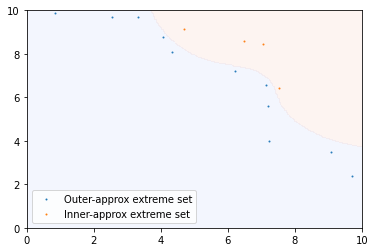

In [43]:
#plot
plt.scatter(x_ext[:, 0], x_ext[:, 1], s=1, c="C0", label="Outer-approx extreme set")
plt.scatter(x_lb_ext[:, 0], x_lb_ext[:, 1], s=1, c="C1", label="Inner-approx extreme set")
plt.contourf(x1s, x2s, ys, cmap="coolwarm", levels=[-100, 0, 100], alpha=0.1)
plt.legend(fontsize=10)
plt.show()

In [44]:
# neural net imports

import torch
import foolbox
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Feed-forward architecture with ReLU
class model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()        
        self.fc2 = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        
        return out

PATH = "net_8.pth"
input_dim = 2
hidden_dim = 8
output_dim = 2
net = model(input_dim, hidden_dim, output_dim).to(device)
net.load_state_dict(torch.load(PATH))
model_net= net

gam = -1.1
sigma_inv = inv(sigma_0)
A1 = model_net.fc1.weight.data.numpy()
B1 = model_net.fc1.bias.data.numpy()
A2 = model_net.fc2.weight.data.numpy()
B2 = model_net.fc2.bias.data.numpy()
signs = [-1,1]

In [45]:
from pylab import *

import shutil
import sys
import os.path
import numpy as np

from pyomo.environ import *

model = AbstractModel()

# For a single layer NN
model.numofinputs = Param(within=NonNegativeIntegers)
model.numofhiddenlayers = Param(within=NonNegativeIntegers)
model.gamma = Param(within=Reals)
model.numofX = Param(within=NonNegativeIntegers)

model.I = RangeSet(1, model.numofinputs)
model.J = RangeSet(1, model.numofhiddenlayers)
model.K = RangeSet(1, model.numofX)

model.A1 = Param(model.J, model.I, within=Reals)
model.B1 = Param(model.J, within=Reals)
model.A2 = Param(model.I, model.J, within=Reals)
model.B2 = Param(model.I, within=Reals)
model.M = Param(within=NonNegativeReals)
model.sgn = Param(model.I, within=Reals)

model.X_hull = Param(model.K, model.I, within=Reals)

model.x = Var(model.I, domain=NonNegativeReals)
model.y = Var(model.J, domain=Reals)
model.z = Var(model.J, domain=Binary)
model.zz = Var(model.K, model.I, domain=Binary)
model.beta = Var(domain=Reals)

# Define the objective function
def obj_function(model):
    return -model.beta
model.obj = Objective(rule=obj_function)

# Define the dominating point constraints as a list
def constraint1(model, i, j):
	return (model.x[j] - model.X_hull[i,j] + 4*model.M*(1-model.zz[i,j]) >= model.beta)
model.cons1 = Constraint(model.K, model.I, rule=constraint1)

def constraint2(model, i):
    return sum(model.zz[i,j] for j in model.I) >= 1
model.cons2 = Constraint(model.K, rule=constraint2)

# Define the NN constraints
def relu_constraint1(model, i):
    return sum(model.A1[i,j] * model.x[j] for j in model.I) + model.B1[i] + model.M*(1-model.z[i]) >= model.y[i]
model.relu1 = Constraint(model.J, rule=relu_constraint1)

def relu_constraint2(model, i):
    return sum(model.A1[i,j] * model.x[j] for j in model.I) + model.B1[i] <= model.y[i]
model.relu2 = Constraint(model.J, rule=relu_constraint2)

def relu_constraint3(model, i):
    return model.M*model.z[i] >= model.y[i]
model.relu3 = Constraint(model.J, rule=relu_constraint3)

def relu_constraint4(model, i):
    return 0 <= model.y[i]
model.relu4 = Constraint(model.J, rule=relu_constraint4)

def g_constraint(model):
    return sum((sum(model.A2[i,j] * model.y[j] for j in model.J) + model.B2[i])*model.sgn[i] for i in model.I) - model.gamma >= 0
model.g_cons = Constraint(rule=g_constraint)

In [46]:
numofextremepts = len(x_ext)
data = {None: {
    'numofinputs': {None: input_dim},
    'numofhiddenlayers': {None: hidden_dim},
    'gamma': {None: gam},
    'numofX': {None: numofextremepts},
    'M':{None: 100000},
    'A1': {(i,j): A1[i-1][j-1] for i in range(1,hidden_dim+1) for j in range(1,input_dim+1)},
    'B1': {i: B1[i-1] for i in range(1,hidden_dim+1)},
    'A2': {(i,j): A2[i-1][j-1] for i in range(1,output_dim+1) for j in range(1,hidden_dim+1)},
    'B2': {i: B2[i-1] for i in range(1,output_dim+1)},
    'X_hull': {(i,j): x_ext[i-1][j-1] for i in range(1,numofextremepts+1) for j in range(1,input_dim+1)},
    'sgn': {i: signs[i-1] for i in range(1,output_dim+1)}
}}

In [47]:
instance = model.create_instance(data)
solver = SolverFactory('gurobi')
result = solver.solve(instance)
instance.solutions.store_to(result)

/home/gurukoushik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/gurukoushik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/gurukoushik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/gurukoushik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gen

In [48]:
print(result)


Problem: 
- Name: x42
  Lower bound: -166787.04198587305
  Upper bound: -166787.04198587305
  Number of objectives: 1
  Number of constraints: 67
  Number of variables: 42
  Number of binary variables: 30
  Number of integer variables: 30
  Number of continuous variables: 12
  Number of nonzeros: 177
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.00604701042175293
  Error rc: 0
  Time: 0.33437156677246094
Solution: 
- number of solutions: 1
  number of solutions displayed: 1
- Gap: 0.0
  Status: optimal
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Objective:
    obj:
      Value: -166787.04198587305
  Variable:
    beta:
      Value: 166787.04198587

In [ ]:
# if negative then it does not lie inside the convex hull